In [1]:
#| default_exp volume_comparison
# Diffusion Curvature utils
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
# Python necessities
import numpy as np
from fastcore.all import *
import matplotlib.pyplot as plt
# Notebook Helpers
from nbdev.showdoc import *
from tqdm.notebook import trange, tqdm
%load_ext autoreload
%autoreload 2

# Scalar Curvature by Volume Comparison
> Based off of Hickock's 2023 method, but using diffusion-based volume estimation.

In our 'Volume Estimation' notebook, we saw that self-diffusion can provide a reasonable estimate of the volume of geodesic balls -- at least on euclidean manifolds, and with a few caveats. Here, we take advantage of this by using a classical formula that relates the ratio of manifold volumes to euclidean volumes to the scalar curvature:

$$
\frac{\operatorname{vol}\left(B^M(x, r)\right)}{\operatorname{vol}\left(B^E(r)\right)}=1-\frac{S(x)}{6(n+2)} r^2+\mathcal{O}\left(r^4\right)
$$

We're inspired here by Hickock's 2023 method, which uses uses density estimation and shortest-path distances to estimate the manifold volume at several scales, and then fits a quadratic to the resulting ratios and extracts from it the scalar curvature. Diffusion has the potential to strengthen this process further, principally by reducing the reliance on shortest-path distances and density estimation. As a nice side effect, this enables Hickock's method to be generalized to graphs that don't come with attached point clouds.

In [2]:
def volume_ratio(A,B):
    """Removes constant offset from both A and B before taking ratio,"""
    A = A + 1e-12 #- np.min(A) 
    B = B + 1e-12 #- np.min(B) 
    return A/B

In [3]:
#|export
import numpy as np
from diffusion_curvature.graphs import get_alpha_decay_graph
from diffusion_curvature.datasets import plane
from diffusion_curvature.volume import volume_via_heat_at_scales, actual_euclidean_volumes_at_radii
def volume_comparisons_of_graph_at_idx(
        G, # pygsp graph
        idx, # node idx to get comparisons from. If None, returns comparisons across all indxs
        dim, # intrinsic dimension of graph/manifold
        ts, # diffusion times at which to give comparison
        use_sampled_euclidean = True,
        verbose=True,
        knn = 15,
        anisotropy = 0.5,
        decay = 20,
        denoising_scale = 5
):
    """Returns the ratio of Vol(B_m)/Vol(B_E) at each of the times"""
    vols_manifold = volume_via_heat_at_scales(G,idx,ts, denoising_scale=denoising_scale)
    radii = np.sqrt(ts)
    if use_sampled_euclidean:
        # TODO: can be expanded to incorporate sampling
        num_points_per_dim = G.L.shape[0]
        X_euc = plane(n=num_points_per_dim, dim=dim)
        G_euc = get_alpha_decay_graph(X_euc,knn=knn,decay=decay,anisotropy=anisotropy) 
        # G_euc = get_alpha_decay_graph(X_euc,knn=G.knn,decay=G.decay,anisotropy=G.anisotropy) 
        vols_euclidean = volume_via_heat_at_scales(G_euc,idx=0,ts=ts,denoising_scale=denoising_scale)
        # if verbose: print(f"G has knn {G.knn}, anisotropy {G.anisotropy}, and decay {G.decay}") # Due to a bug in graphtools, these values aren't accurate.
    else:
        vols_euclidean = actual_euclidean_volumes_at_radii(dim, radii)
    if len(vols_manifold.shape) == 3: # we've computed volumes at all indxs
        ratios = []
        for VM in vols_manifold:
            ratios.append(VM/vols_euclidean)
        return np.array(ratios)
    else:
        return vols_manifold/vols_euclidean

In [4]:
#|export
def extract_scalar_curvature(
        radii, 
        volume_ratios,
        dim,
        verbose=False
        ):
    coeffs = np.polyfit(radii, volume_ratios, deg=3) # highest power returned first
    if verbose: print(f"Coeffs are {coeffs}")
    S = -coeffs[1]*6*(dim+2)
    return S

A second attempt to extract curvature while compensating for an offset between radius and volume.
See https://share.museapp.com/link/29e6c2c4721095213ca544a8ad976408 for details.

In [5]:
#| export
from diffusion_curvature.volume import calculate_radius_offset
def extract_scalar_curvature_with_offset_compensation(
        ts,
        volume_ratios,
        dim,
        verbose=False,
):
    ts_adjusted = np.sqrt(ts)
    # since the polynomial is in sqrt(t)
    coeffs = np.polyfit(ts_adjusted, volume_ratios, deg=2) 
    # highest power returned first 
    if verbose:print(f"returned coeffs are")
    offset = calculate_radius_offset(dim)
    S_prime = (-coeffs[1]**2)/(4*coeffs[0]*offset)
    S = S_prime*6*(dim+2)
    return S


# Sampling Space Comparison

As a fallback, if the analytic volume estimation is too hard to compare with our heat kernel volume, we can construct a euclidean space of equivalent dimension (and equivalent sampling) and simply compare volumes to this.

### The Plane
This is the most basic example. The volume ratios here should be flat.

In [6]:
globalts = 1+(np.arange(4,15)/3)**2
globalts

array([ 2.77777778,  3.77777778,  5.        ,  6.44444444,  8.11111111,
       10.        , 12.11111111, 14.44444444, 17.        , 19.77777778,
       22.77777778])

In [7]:
from diffusion_curvature.graphs import *
def ratios_of_plane(idx):
    X = plane(2000)
    G = get_alpha_decay_graph(X,knn=20,decay=20,anisotropy=1)  
    ts = globalts
    h_ratios = volume_comparisons_of_graph_at_idx(G,idx,dim=2,ts=ts, knn=20, decay=20, anisotropy=1)
    return h_ratios

In [8]:
plane_ratios_in_bulk = np.array(
    perform_trials(ratios_of_plane,n_trials=20, n_workers=10, idx=0)
)

0it [00:00, ?it/s]

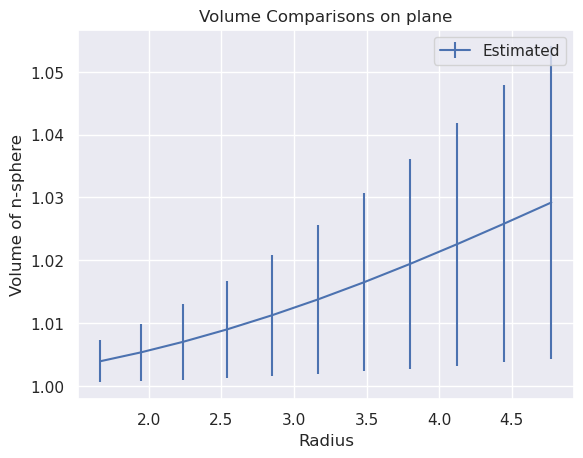

In [95]:
plot_array(plane_ratios_in_bulk,xs = np.sqrt(globalts),title="Volume Comparisons on plane")

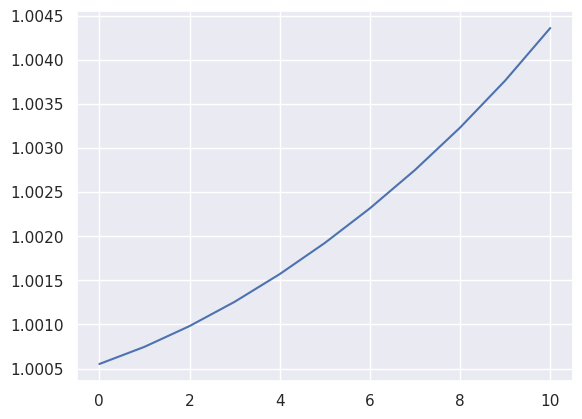

In [96]:
plt.plot(plane_ratios_in_bulk[10])

In [26]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.graphs import *
X, ks = torus(10000, use_guide_points=True)
G_torus = get_alpha_decay_graph(X)

In [27]:
ts = np.array([1,2,3,4,5,6,7])**2
torus_ratios = volume_comparisons_of_graph_at_idx(G_torus,0,2,ts)

/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion_curvature/diffusion_curvature/heatkernel.py:33: RuntimeWarning: overflow encountered in scalar power
  * (C ** (K + 1))
/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion_curvature/diffusion_curvature/heatkernel.py:31: RuntimeWarning: invalid value encountered in scalar divide
  2


In [28]:
extract_scalar_curvature(np.sqrt(ts), torus_ratios, 2, verbose=True)

Coeffs are [-0.05697424  0.82638028 -3.8177561   6.76538644]


-19.833126653891636

## An experiment: the torus in detail
The torus contains regions of both negative and positive curvature, allowing us to examine how the method responds to each of these.

In [147]:
def ratios_of_torus(idx):
    X, ks = torus(2000, use_guide_points=True)
    knn = 10
    anisotropy = 1
    decay = 20
    denoising = 5
    G_torus = get_alpha_decay_graph(X,knn=knn, anisotropy=anisotropy,decay=decay)  
    ts = globalts
    torus_ratios = volume_comparisons_of_graph_at_idx(G_torus,idx,dim=2,ts=ts, knn=knn, anisotropy=anisotropy, decay=decay, denoising_scale=denoising)
    return torus_ratios

Let's first see what diffusion on the torus looks like at the scale of our chosen ts.

In [148]:
X, ks = torus(2000, use_guide_points=True)
G_torus = get_alpha_decay_graph(X,knn=10, anisotropy=0.5,decay=20)

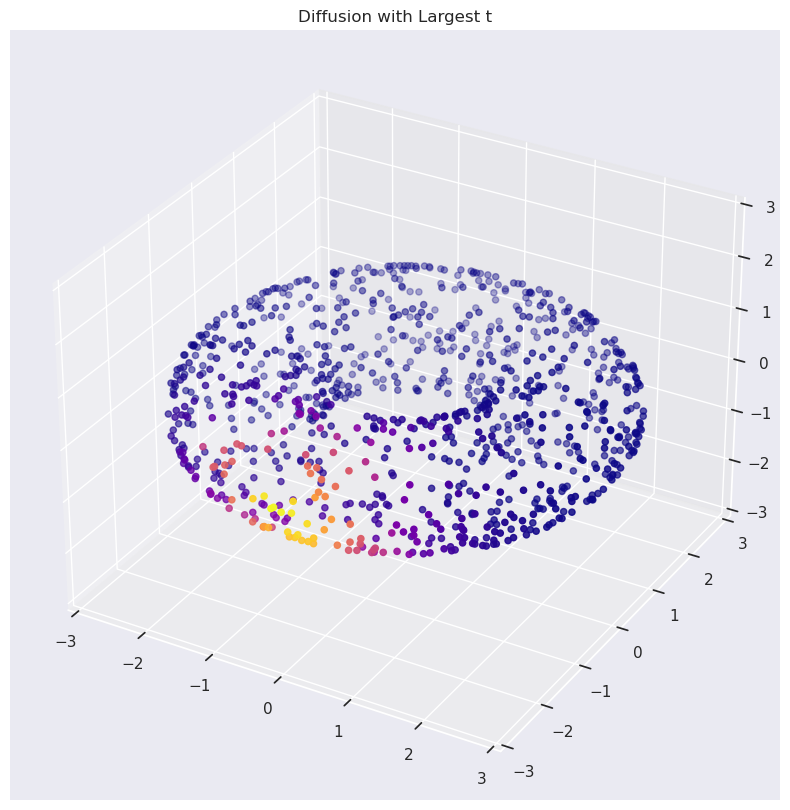

In [149]:
from diffusion_curvature.heatkernel import heat_diffusion_on_signal
diffused_diracs = heat_diffusion_on_signal(G_torus,kronecker_delta(X,0),globalts)
plot_3d(X,diffused_diracs[-1],title="Diffusion with Largest t")

The diffusion is well contained within the region of curvature, hence this t value *seems* reasonable.

In [150]:
from diffusion_curvature.utils import perform_trials
torus_ratios_in_bulk = np.array(
    perform_trials(ratios_of_torus,n_trials=50, idx=0))

0it [00:00, ?it/s]

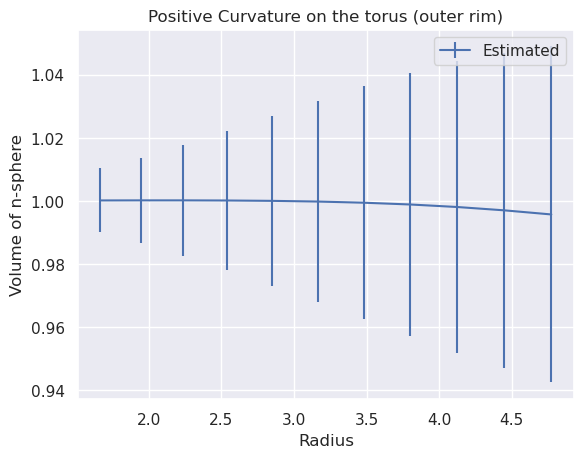

In [151]:
plot_array(torus_ratios_in_bulk,np.sqrt(globalts), title="Positive Curvature on the torus (outer rim)")

In [34]:
from diffusion_curvature.utils import perform_trials
torus_ratios_in_bulk = np.array(
    perform_trials(ratios_of_torus,n_trials=50, idx=1))

0it [00:00, ?it/s]

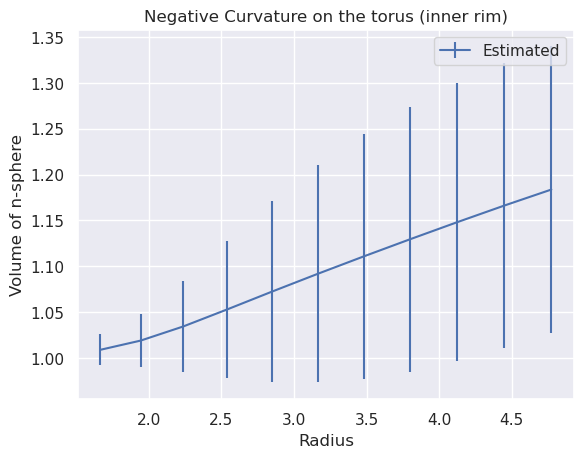

In [35]:
plot_array(torus_ratios_in_bulk,np.sqrt(globalts), title="Negative Curvature on the torus (inner rim)")

## Experiment with different manifolds

### The Saddle

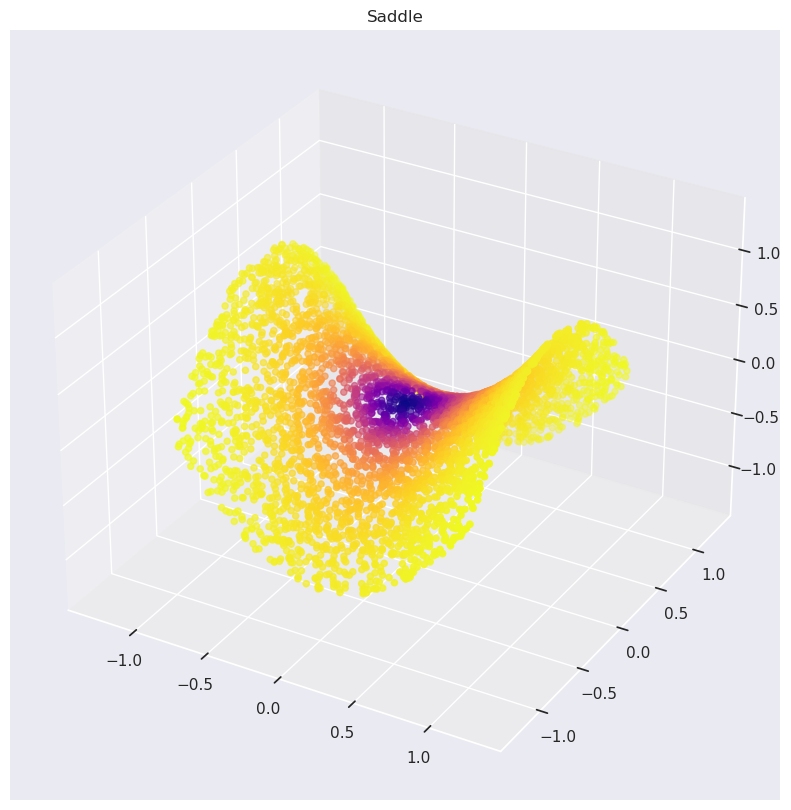

In [66]:
X, ks = paraboloid(5000, use_guide_points=True)
plot_3d(X,ks,"Saddle")

In [68]:
def ratios_of_saddle(idx):
    X, ks = paraboloid(5000, use_guide_points=True)
    G = get_alpha_decay_graph(X,knn=10, anisotropy=0.5, decay=20)  
    ts = globalts
    h_ratios = volume_comparisons_of_graph_at_idx(G,idx,dim=2,ts=ts, knn=10, anisotropy=0.5, decay=20)
    return h_ratios

In [69]:
saddle_ratios_in_bulk = np.array(
    perform_trials(ratios_of_saddle,n_trials=50, idx=0))

0it [00:00, ?it/s]

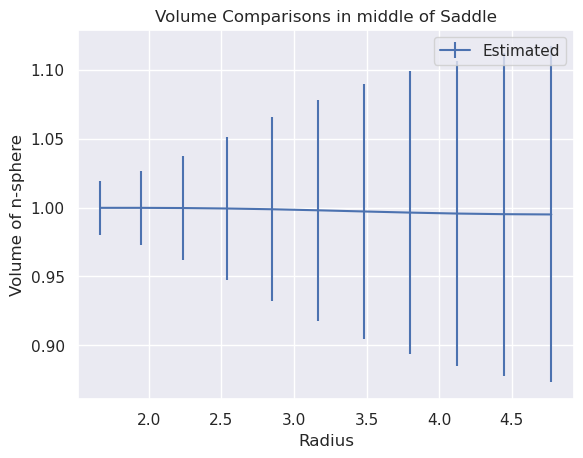

In [70]:
plot_array(saddle_ratios_in_bulk,np.sqrt(globalts),"Volume Comparisons in middle of Saddle")

### The Sphere

In [40]:
def ratios_of_sphere(idx):
    X, ks = sphere(2000, use_guide_points=True)
    G = get_alpha_decay_graph(X,knn=10, decay=20, anisotropy=0.5)  
    ts = globalts
    h_ratios = volume_comparisons_of_graph_at_idx(G,idx,dim=2,ts=ts, decay=20, knn=10, anisotropy=0.5)
    return h_ratios

In [41]:
sphere_ratios_in_bulk = np.array(
    perform_trials(ratios_of_sphere,n_trials=50, idx=0))

0it [00:00, ?it/s]

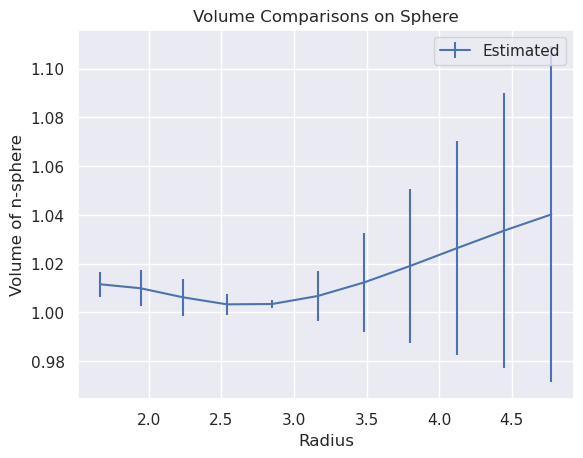

In [42]:
plot_array(sphere_ratios_in_bulk,np.sqrt(globalts),"Volume Comparisons on Sphere")

# Computing Scalar Curvature across a manifold

In [83]:
#|export
from tqdm.notebook import trange
def scalar_curvatures_of_graph(
    G, 
    dim,
    ts = np.arange(1,10),
    knn=15,
    decay=20, 
    anisotropy=0.5
):
    ks = np.empty(G.L.shape[0])
    ratios_all_i = volume_comparisons_of_graph_at_idx(
            G,
            None, # compute for all idx
            dim,
            ts,
            knn=knn,decay=decay, anisotropy=anisotropy
        )
    for i in trange(len(ks)):
        ratios = ratios_all_i[i]
        ks[i] = extract_scalar_curvature_with_offset_compensation(np.sqrt(ts),ratios,dim)
    return ks

In [84]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.graphs import *
X, ks = torus(5000)
G_torus = get_alpha_decay_graph(X, knn=15,decay=20, anisotropy=0.5)

In [85]:
ks_torus = scalar_curvatures_of_graph(G_torus,dim=2,knn=15,decay=20, anisotropy=0.5)

(2481, 9)


  0%|          | 0/2481 [00:00<?, ?it/s]

In [89]:
# remove outliers from ks
import numpy as np
def set_outliers_to_zero(array, threshold):
    """
    Sets outliers in a numpy array to zero.

    Parameters:
    - array: NumPy array
    - threshold: The maximum allowed distance from the median value to consider a data point as an outlier.

    Returns:
    - array with outliers set to zero
    """
    median = np.median(array)
    distance = np.abs(array - median)
    median_absolute_deviation = np.median(distance)
    modified_z_score = 0.6745 * distance / median_absolute_deviation

    array[modified_z_score >= threshold] = 0
    return array
ks_torus = set_outliers_to_zero(ks_torus,3)


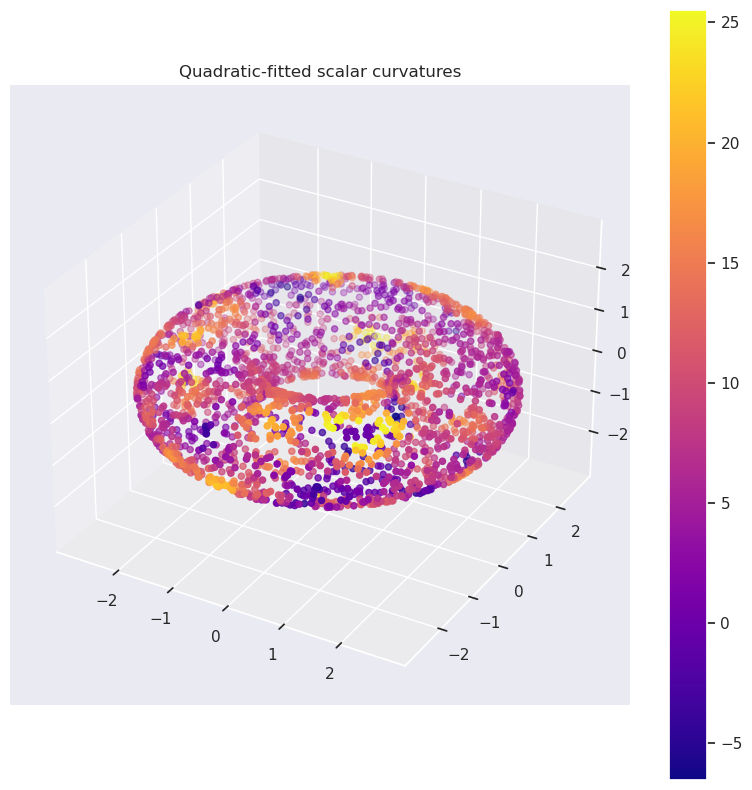

In [90]:
plot_3d(X,ks_torus,"Quadratic-fitted scalar curvatures", colorbar=True)

In [87]:
min(ks_torus)

-132.3916304212383

In [88]:
max(ks_torus)

184.53685891998666

In [50]:
G_torus.knn

5

In [51]:
G_torus.anisotropy

0

In [52]:
G_torus.decay

40